# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from itertools import product as it_product

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

# Parameters

In [2]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [3]:
all_data_path = r'../../data/snow_data_clean.parquet'

In [4]:
def resample_by_month(df, time_col):
    """resample df on monthly basis using specified timestamp column"""
    df = df.reset_index()
    # handling of time_col
    acceptable_time_col = ['timestamp', 'pseudo_ts']
    other_time_col = [x for x in acceptable_time_col if x != time_col].pop()
    if time_col not in acceptable_time_col:
        raise Exception(f'must be in {acceptable_time_col}')
    
    month = (df
             .set_index(f'{time_col}')
             .groupby([pd.Grouper(freq='1MS'), 'station'])
             .agg({'base': 'mean', 'snowfall': 'sum', 
                   'region': 'first', 'state': 'first', 'ski_yr': 'first',
                   f'{other_time_col}': 'first'})
            )
    return month

In [5]:
def index_setter(df=None, freq='M', index="pseudo_ts"):
    """sets index to just timestamp and sets frequency of timestamp"""
    try:
        df = df.reset_index(level='station')
    except KeyError:
        df = df.set_index(index)
    df.index = pd.DatetimeIndex(df.index.values, freq=freq)
    return df

In [6]:
long_series_df = pd.read_parquet(all_data_path).reset_index().set_index('pseudo_ts')
assert long_series_df.base.isna().sum()==0
month_ts_df = long_series_df.pipe(resample_by_month, time_col='pseudo_ts')
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .query('state=="colorado"')
              #.pipe(index_setter, freq='MS')
              .sort_values(by='pseudo_ts')
              .dropna(how='all')
             )

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [7]:
def AC_PAC_plotter(df=None, lags=30, differences=None):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    smg.tsaplots.plot_acf(x=df.base,
                          lags=lags, alpha=0.05,
                          use_vlines=True, unbiased=False,
                          missing='conservative',
                          title=f'Autocorrelation: Differencing: {differences}',
                          zero=True, ax=ax1
                          )
    smg.tsaplots.plot_pacf(x=df.base, lags=lags,
                           alpha=0.05, method='ldb', use_vlines=True,
                           title='Partial Autocorrelation', zero=True,
                           vlines_kwargs=None, ax=ax2)
    fig

In [8]:
def resid_plotter(residuals=None, y=None):
    """plot residual errors, exactly what it says on the tin"""
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    residuals.plot(title="Residuals over Time", ax=ax1)
    residuals.plot(kind='kde', title="Residuals Distribution", ax=ax2)
    plt.show()
    print(residuals.describe())

In [112]:
def y_and_yhat_plotter(model=None, data=None, test_data=None, steps=5):
    """plots values and model predictions
    Inputs:
        model: a fit model
        data: df with time series data and pseudo_ts index
        exog_col: column name"""
    # copy for both plots
    model_multi = model
    df = df_multi = data.copy().rename(columns={'base': 'y'})
    test_df = test_multi_df = test_data.copy().rename(columns={'base': 'y'})
    
    df = pd.concat([df, test_df], axis=0)
    
    df['yhat'] = model.predict(df, steps=1, include_ci=True, dynamic=False)
    df['lowerCI'] = model.prediction_ci.iloc[:, 0]
    df['upperCI'] = model.prediction_ci.iloc[:, 1]
    
    test_multi_df['yhat'] = model_multi.predict(test_multi_df, steps=steps, 
                                           include_ci=True, dynamic=(test_multi_df.shape[0]-1))
    test_multi_df['lowerCI'] = model_multi.prediction_ci.iloc[:, 0]
    test_multi_df['upperCI'] = model_multi.prediction_ci.iloc[:, 1]
    
    df_multi = pd.concat([df_multi, test_multi_df])

    # skip first value: predictions are based on prior values
    df2, df_multi2 = df.iloc[1:, :], df_multi.iloc[1:, :]

    def melt_predicts(df):
        return (df
                .reset_index()
                .rename(columns={'index': 'pseudo_ts'})
                .melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
                )
    melted_df2 = melt_predicts(df)
    melted_df_multi2 = melt_predicts(df_multi)

    fig, axes = plt.subplots(2, 1, figsize=(18, 6))

    def plot_sub(y, ci_data, axis):
        sns.lineplot(data=y, x='pseudo_ts', y='value', hue='variable',
                     marker='x', ax=axis)
        axis.fill_between(ci_data.index, ci_data.lowerCI,
                          ci_data.upperCI, alpha=.3)
    data = (df2, df_multi2)
    melted_data = (melted_df2, melted_df_multi2)
    for datum, melted_datum, axis in zip(data, melted_data, axes):
        plot_sub(y=melted_datum, ci_data=datum, axis=axis)
    axes[0].set_title("One Step Prediction over Train & Test")
    axes[1].set_title("Recursive Prediction on Test Set")

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

In [10]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """wrap statsmodels ARIMA models to expose sklearn-style API"""

    def __init__(self, model_class, order, seasonal_order=None, has_exog=None,
                 endog_col_name='base'):
        self.model_class = model_class
        self.order = order
        self.seasonal_order = seasonal_order
        self.has_exog = has_exog
        self.endog_col_name = endog_col_name

    def fit(self, X=None, Y=None):
        self.endog = X[self.endog_col_name]
        if self.has_exog is not None:
            self.exog = X[[col for col in X.columns if col !=
                           self.endog_col_name]]
        else:
            self.exog = None
        model_class_args = dict(endog=self.endog, exog=self.exog,
                                order=self.order,  # dates=self.endog.index,
                                seasonal_order=self.seasonal_order,)
        # model_class_args = {k:v for k, v in model_class_args.items()
        #                    if v is not None}  # filter Nones even if series
        self.sm_model_ = self.model_class(**model_class_args)
        self.results_ = self.sm_model_.fit()
        self.resid = self.results_.resid
        self.plot_diagnostics = self.results_.plot_diagnostics
        self.mse, self.mae = self.results_.mse, self.results_.mae
        self.bic, self.aic = self.results_.bic, self.results_.aic
        # return self.results_

    def predict(self, X=None, steps=1, include_ci=False, **kwargs):

        try:
            self.predict_exog = X.iloc[:, 1:-1]
        except:
            self.predict_exog = None
        self.prediction_results = self.results_.get_prediction(start=X.iloc[0].name,
                                                 end=X.iloc[-1].name,
                                                 exog=self.predict_exog,
                                                 steps=steps,
                                                 **kwargs)
        self.predictions = self.prediction_results.predicted_mean
        if include_ci:
            self.prediction_ci = self.prediction_results.conf_int()
        return self.predictions

    def summary(self):
        return self.results_.summary()

In [11]:
def time_crossval(model, X, y):
    """takes sklearn-API model and returns CV results
    input:
        model: sklearn-API model
        X: 
        Y:
    """
    time_split = TimeSeriesSplit(8)
    cv_results = cross_validate(model, X, y, cv=time_split, 
                            scoring=['neg_root_mean_squared_error', 'r2',
                                     'neg_mean_absolute_error'], n_jobs=1) 
    return cv_results

In [12]:
def pdq_maker(order_limit=2, s_order_limit=1, period=12):
    """generate all possible SARIMA orders for range"""
    p = d = q = range(0, order_limit)
    P = D = Q = range(0, s_order_limit)
    # Generate all different combinations of pdq/PDQ triplets
    pdq = list(it_product(p, d, q))
    seasonal_PDQ = [(x[0], x[1], x[2], period) for x in list(it_product(p, d, q))]
    return (pdq, seasonal_PDQ)

def IC_chooser(unwrapped_mod=None, X=None, y=None, order_limit=(2,1)):
    """Use AIC/BIC to choose best model from grid of (pdq)(PDQ)S models
    Params:
        model:  sklearn model
        X:  
        y:
        order_limit:  tuple of highest order to use for pdq/PDQ
    Returns:
        df of AIC/BIC statistics
    """
    pdq, seasonal_pdq = pdq_maker(*order_limit)
    AIC, BIC = {}, {}
    for order in pdq:
        for season_order in seasonal_pdq:
            model = SMWrapper(unwrapped_mod, order=order, seasonal_order=season_order)
            model.fit(X=X)
            AIC[f"{order}{season_order}12"] = model.aic
            BIC[f"{order}{season_order}12"] = model.bic
    ic_df = (pd.DataFrame.from_dict(AIC, orient='index').rename(columns={0:"AIC"})
             .merge(right=
                   pd.DataFrame.from_dict(BIC, orient='index').rename(columns={0:"BIC"}),
                   left_index=True, right_index=True)
             .sort_values(by='BIC', ascending=True)
             )
    return ic_df

## ARIMA and extensions

<Figure size 792x504 with 0 Axes>

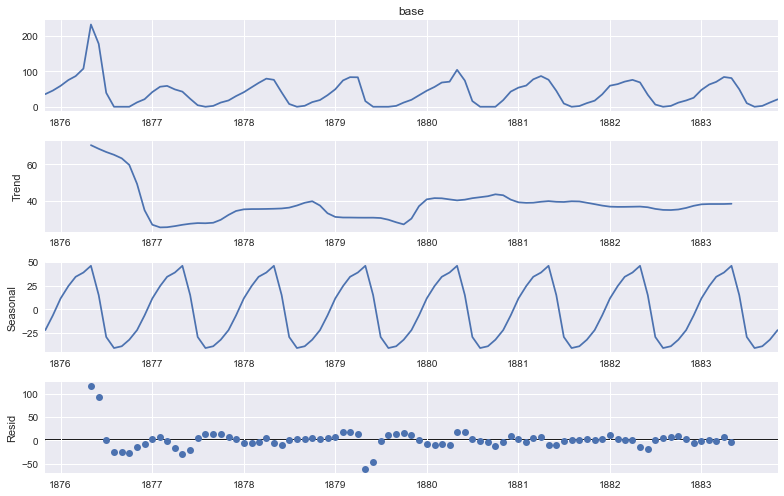

In [13]:
def train_test_split(df=month_ts_df, station=None, exog_cols=None, ski_yr_cutoff=7):
    """returns Train Test by year for one station"""
    cols = ['base', 'ski_yr']
    if exog_cols:
        cols.extend(exog_cols)
    subset =  df.query('station==@station') \
    .pipe(index_setter, freq="MS",
          index='timestamp').fillna(0) \
    .filter(items=cols)
    train = subset.query('ski_yr<=@ski_yr_cutoff').drop(columns=['ski_yr'])
    test = subset.query('ski_yr>@ski_yr_cutoff').drop(columns=['ski_yr'])
    return train, test
    
    
WP_train, WP_test = train_test_split(station="Winter Park")
decomposition = smt.seasonal.seasonal_decompose(WP_train.base, period=12)
fig = plt.figure()
fig = decomposition.plot();

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

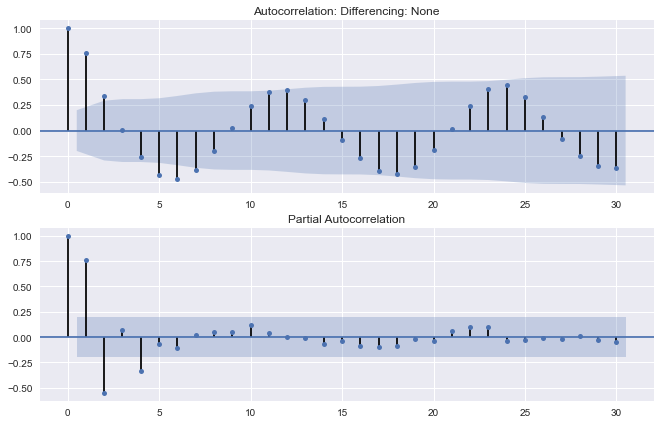

In [14]:
AC_PAC_plotter(WP_train)

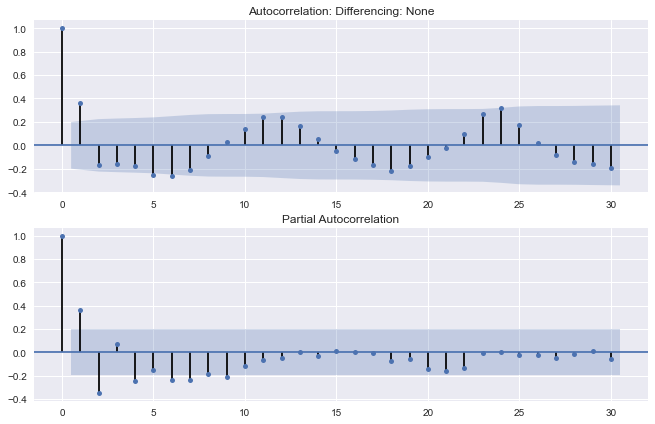

In [15]:
AC_PAC_plotter(WP_train.assign(base=lambda x: x.base.diff(periods=1)).fillna(0))

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.
I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [16]:
# try crossvalition on model 
# (p, d, q) | (AR, diff, MA) ; 
arima_model = SMWrapper(model_class=smt.arima.model.ARIMA, 
                        order=(0, 1, 1))

arima_model.fit(X=WP_train)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   base   No. Observations:                   97
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -438.932
Date:                Fri, 26 Jun 2020   AIC                            881.865
Time:                        09:48:31   BIC                            886.994
Sample:                    11-01-1875   HQIC                           883.938
                         - 11-01-1883                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5950      0.033     18.280      0.000       0.531       0.659
sigma2       545.6533     30.880     17.670      0.000     485.130     606.177
===================================================================================
Ljung-Box (Q):                       49.09   Jarque-Bera (JB):               622.00
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

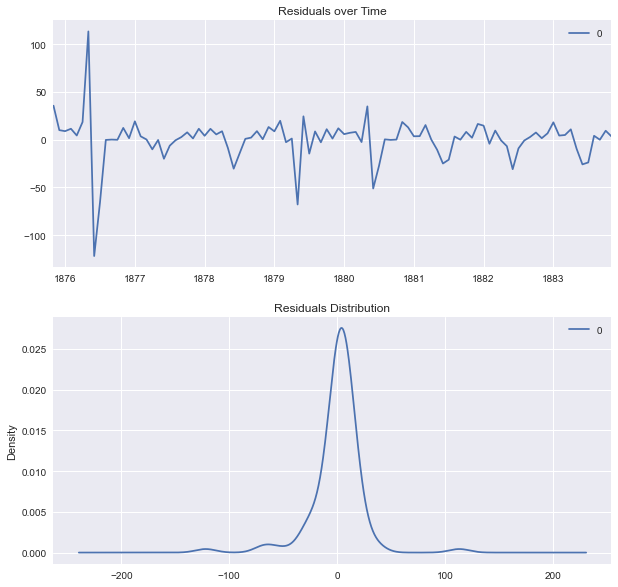

                0
count   97.000000
mean     0.299525
std     23.652201
min   -121.871490
25%     -2.462849
50%      2.778492
75%      8.978470
max    113.407677


In [17]:
arima_resids = pd.DataFrame(arima_model.resid)
resid_plotter(arima_resids)

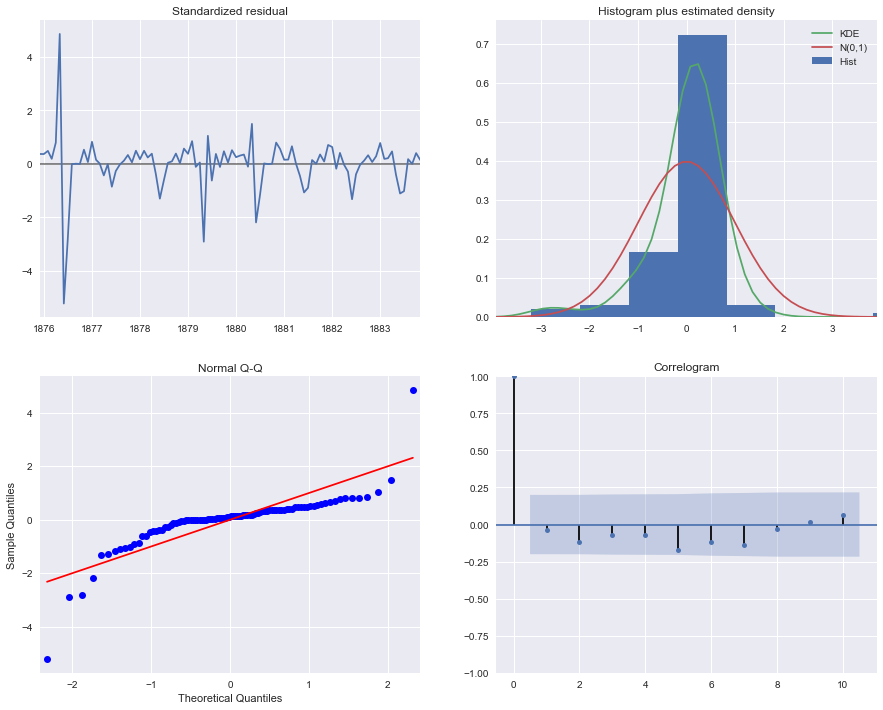

In [18]:
_ = arima_model.plot_diagnostics(figsize=(15, 12))

In [19]:
# could use full dataset for IC-based selection
IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=WP_train,  
           y=WP_train.shift(1), order_limit=(2, 0))\
.applymap((lambda x : "{:,.0f}".format(x)))

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,AIC,BIC
"(1, 0, 1)(1, 1, 1, 12)12",754,767
"(1, 0, 1)(1, 1, 0, 12)12",757,767
"(1, 0, 1)(0, 1, 1, 12)12",758,767
"(0, 0, 1)(0, 1, 1, 12)12",765,772
"(0, 0, 1)(1, 1, 0, 12)12",766,773
...,...,...
"(1, 0, 0)(0, 0, 0, 12)12",906,914
"(0, 0, 0)(1, 0, 1, 12)12",940,950
"(0, 0, 0)(1, 0, 0, 12)12",957,965
"(0, 0, 0)(0, 0, 1, 12)12",975,983


there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


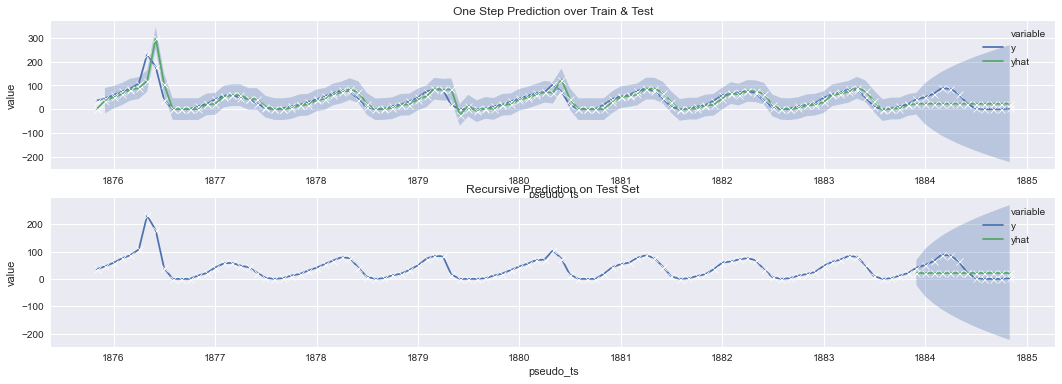

In [113]:
y_and_yhat_plotter(model=arima_model, data=WP_train, test_data=WP_test)

In [102]:
time_crossval(model=arima_model, X=WP_train, 
              y=WP_train.shift(1).fillna(0))

{'fit_time': array([0.04942346, 0.05186272, 0.06115317, 0.06942606, 0.07849216,
        0.07790136, 0.08285499, 0.08581352]),
 'score_time': array([0.00797796, 0.01199317, 0.01386166, 0.02094483, 0.01598907,
        0.0199492 , 0.02194214, 0.02189875]),
 'test_neg_root_mean_squared_error': array([-40.11467875, -29.6092242 , -36.70606434, -55.69382211,
        -47.95088291, -46.54105119, -53.2285364 , -35.32411312]),
 'test_r2': array([-3.20414995, -0.03072483, -0.25990795, -2.35166187, -1.34876248,
        -2.08458057, -2.54235029, -0.27063741]),
 'test_neg_mean_absolute_error': array([-35.02036239, -25.87071507, -28.7643808 , -46.65136577,
        -36.3366425 , -39.47593553, -45.09376181, -29.27091286])}

this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [103]:
IC_results = IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=WP_train,
                        y=WP_train.shift(1), order_limit=(2, 1))

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [104]:
IC_results.applymap(lambda x : "{:,.0f}".format(x))

,AIC,BIC
"(1, 0, 1)(1, 1, 1, 12)12",754,767
"(1, 0, 1)(1, 1, 0, 12)12",757,767
"(1, 0, 1)(0, 1, 1, 12)12",758,767
"(0, 0, 1)(0, 1, 1, 12)12",765,772
"(0, 0, 1)(1, 1, 0, 12)12",766,773
...,...,...
"(1, 0, 0)(0, 0, 0, 12)12",906,914
"(0, 0, 0)(1, 0, 1, 12)12",940,950
"(0, 0, 0)(1, 0, 0, 12)12",957,965
"(0, 0, 0)(0, 0, 1, 12)12",975,983


In [105]:
sarima_model = smt.arima.model.ARIMA(endog=WP_train, order=(0, 1, 1),
                                     seasonal_order=(0, 1, 0, 12))
sarima_model.fit(WP_train)

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\tools.py:502: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [106]:
sarima_model.summary()

AttributeError: 'ARIMA' object has no attribute 'summary'

# Regression with SARIMA Errors
Similar to ARIMAX but with more interpretable coefficients.  
Pace the name, StatsModels actually implements Regression with SARIMA errors, not ARIMAX.  
using snowfall data with powder -> packed powder and melt inference

In [ ]:
reg_w_sarima = smt.statespace.sarimax.SARIMAX(endog=month_ts_df.base, exog=month_ts_df.snowfall,
                                              order=(0,1,1), seasonal_order=(0,1,0,12))
reg_w_sarima_results = reg_w_sarima.fit()

In [ ]:
reg_w_sarima_results.summary()

In [ ]:
reg_w_sarima_results.predict(endog=month_ts_df.base, exog=month_ts_df.snowfall,)

In [ ]:
y_and_yhat_plotter(model=reg_w_sarima, endog=month_ts_df.base, exog=month_ts_df.snowfall,)

In [ ]:
snow_beta_df = (pd.DataFrame({'station': ['test'], 'beta': [0], 'region': ['test']})
                .drop(index=0))  # avoid pd forcing region column to numeric
month_reset = month_ts_df.reset_index().set_index('timestamp').asfreq('M')
for station in month_reset.station.unique():
    station_df = month_reset[month_reset.station==station]
    reg_w_sarima = smt.statespace.sarimax.SARIMAX(endog=station_df.base, 
                                                  exog=station_df.snowfall,
                                                  order=(0,1,1), 
                                                  seasonal_order=(0,1,0,12))
    results = reg_w_sarima.fit()
    snow_beta_df.at[station, 'beta'] = results.params.snowfall
    snow_beta_df.at[station, 'region'] = station_df.region[0]

In [ ]:
snow_beta_df.head()

In [ ]:
sns.boxplot(data=snow_beta_df, x='region', y='beta')
plt.title('Snowfall beta: Estimate of how an inch of snowfall will affect base depth, after accounting for time series effect e.g. seasonal change');

#### Other models
GARCH, Gaussian Process, hidden Markov

### Bayesian Structural Model
[example bsm in R](https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/),  
[use tensorflow probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html),  
[tfp example notebook: link](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb), 

### Panel Models
Linearmodels module?